In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from models.train_utils import create_input_iter
from models.egnn_jax import EGNN
from models.graph_utils import rotate_representation

In [4]:
from datasets import load_data

In [5]:
n_nodes = 300
n_batch = 4
n_samples = 4

In [6]:
train_ds, norm_dict = load_data("nbody", 3, n_nodes, n_batch, 234, small=True, n_samples=n_samples)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [7]:
tuple(map(float, norm_dict['mean']))

(497.149658203125, 499.62109375, 498.3173522949219)

In [8]:
batches = create_input_iter(train_ds)
x_data = next(batches)
x = x_data[0][0]
cond = x_data[1][0]

In [9]:
k = 20

In [10]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x, k)

In [11]:
def translate_pbc(coordinates, translation_vector, box_size):
    """
    Translate a batch of coordinates and apply periodic boundary conditions.

    :param coordinates: np.array of shape (batch, points, 3) containing the coordinates
    :param translation_vector: np.array of shape (3,) containing the translation vector
    :param box_size: float representing the box size
    :return: np.array of shape (batch, points, 3) containing the translated coordinates
    """

    # Translate the coordinates
    translated_coordinates = coordinates + translation_vector

    # Apply periodic boundary conditions
    translated_coordinates = np.mod(translated_coordinates, box_size)

    return translated_coordinates

## EGNN; equivariance test

Just the base GNN. Rotate the box and check if the output is equivariant.

In [12]:
coord_mean, coord_std, box_size = norm_dict['mean'], norm_dict['std'], 1000.
unit_cell = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [13]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, graph, pos):
        return jax.vmap(EGNN(k=k), in_axes=(0, 0, 0, 0, None, None, None, None))(graph, pos, None, None, coord_mean, coord_std, box_size, unit_cell)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

In [14]:
d2 = np.sum(x ** 2, axis=-1, keepdims=True)

### Rotation equivariance

In [15]:
pos = x
pos_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45, np.array([0., 0., 1.]))

In [16]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_out, _ = model.init_with_output(rng, graph, pos)

In [17]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_rot_out, _ = model.init_with_output(rng, graph, pos_rot)

In [18]:
pos_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(pos_out, 45, np.array([0., 0., 1.]))

In [19]:
pos_rot_out / pos_out_rot

Array([[[0.9999992 , 0.99999917, 0.9999932 ],
        [1.0000018 , 0.99999535, 1.000002  ],
        [0.99999815, 1.0000008 , 1.0000007 ],
        ...,
        [1.0000011 , 0.99999857, 0.9999997 ],
        [0.99999946, 0.9999982 , 1.0000011 ],
        [1.0000002 , 1.0000013 , 1.0000004 ]],

       [[0.99999654, 1.0000008 , 0.99999994],
        [0.99976325, 1.0000007 , 1.0000025 ],
        [0.99999815, 1.0000017 , 1.0000105 ],
        ...,
        [1.000001  , 0.999988  , 0.9999959 ],
        [1.0000021 , 0.99999875, 0.99997866],
        [0.9999996 , 1.0000005 , 1.0000002 ]],

       [[0.9999983 , 1.0000026 , 1.0000017 ],
        [1.000001  , 0.9999997 , 1.0000017 ],
        [0.9999988 , 0.9999992 , 0.99999946],
        ...,
        [1.0000005 , 1.0000013 , 0.9999972 ],
        [1.0000033 , 0.9999987 , 0.9999967 ],
        [1.        , 1.0000012 , 0.99999964]],

       [[1.        , 1.0000004 , 0.9999998 ],
        [0.9999999 , 0.99999934, 0.9999967 ],
        [1.0000012 , 0.99999726, 1.

### Translation equivariance

In [20]:
tran = np.array([-0.45, 0.9, -1.2])[None, None, :]
pos_tran = pos + tran
pos_out_tran = pos_out + tran

In [21]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [22]:
pos_tran_out / pos_out_tran

Array([[[ 0.03320584,  0.07232709, -0.00206603],
        [ 0.04164192, -0.0067274 , -0.00393614],
        [-0.1801723 , -0.12467702,  0.04299268],
        ...,
        [-0.33494264, -0.03799701,  0.06276979],
        [ 0.08157434, -0.05360464,  0.04211402],
        [ 0.06376956, -0.01228087,  0.03388238]],

       [[ 0.01924628, -0.05975367,  0.0434353 ],
        [-0.09125391, -0.04417643,  0.00620808],
        [ 0.04337419,  0.00823863,  0.00226015],
        ...,
        [ 0.02080166, -0.02710756, -0.00765987],
        [ 0.13739301,  0.0395862 , -0.00122977],
        [-0.06900207, -0.01373811,  0.00866589]],

       [[-0.06808295,  0.01241031, -0.00937655],
        [-0.0040789 ,  0.05547327,  0.03670129],
        [-0.08305148, -0.1722638 , -0.04228091],
        ...,
        [ 0.1950271 , -0.05991929, -0.02405283],
        [ 0.00660909, -0.01010211, -0.00094546],
        [-0.07162683,  0.01844902,  0.02052966]],

       [[-0.12930466, -0.18525133,  0.03146324],
        [-0.12059309,  0

In [23]:
tran = np.array([700., 100., 800.])
pos_tran = (translate_pbc(pos * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
pos_out_tran = (translate_pbc(pos_out * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std

In [24]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [25]:
pos_tran_out / pos_out_tran

Array([[[ 0.01476497,  0.16719201, -0.00354911],
        [ 0.01860623, -0.01750798, -0.00677105],
        [-0.07136616, -0.39947367,  0.07154691],
        ...,
        [-0.12293456, -0.10406701,  0.10304518],
        [ 0.03730848, -0.15075488,  0.07012752],
        [ 0.02886178, -0.03224593,  0.05674465]],

       [[ 0.00848983, -0.16984475,  0.07226115],
        [-0.03786865, -0.12225688,  0.01060191],
        [ 0.01939959,  0.02094215,  0.00387072],
        ...,
        [ 0.00918403, -0.07291285, -0.01321175],
        [ 0.06498057,  0.09594934, -0.00211129],
        [-0.02898026, -0.03615687,  0.0147734 ]],

       [[-0.02860843,  0.03134292, -0.01619264],
        [-0.00177567,  0.13136283,  0.06134478],
        [-0.03461697, -0.6087125 , -0.07478838],
        ...,
        [ 0.09560551, -0.17036463, -0.04198116],
        [ 0.00289449, -0.02643273, -0.00162288],
        [-0.03003986,  0.04616354,  0.03470574]],

       [[-0.05258632, -0.6735099 ,  0.05278239],
        [-0.0492691 ,  0

## Look at VLB loss

In [26]:
from models.diffusion import VariationalDiffusionModel
from flax.core import FrozenDict
from models.diffusion_utils import loss_vdm
from models.train_utils import create_input_iter, param_count, train_step

In [27]:
train_ds, norm_dict_tmp = load_data("nbody", 3, n_nodes, n_batch, 23, small=True)

In [28]:
batches = create_input_iter(train_ds)

In [29]:
x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

In [30]:
score_dict = FrozenDict({"k":20, "n_pos_features":3})  # GNN args
# score_dict = FrozenDict({"k":20, "n_pos_features":3, "latent_size":53, "num_mlp_layers":2, "message_passing_steps":4})  # GNN args
score = "egnn"

encoder_dict = decoder_dict = FrozenDict({})
norm_dict = FrozenDict({"x_mean":tuple(map(float, norm_dict_tmp['mean'])), "x_std":tuple(map(float, norm_dict_tmp['std'])), "box_size":1000.})  # GNN args

vdm = VariationalDiffusionModel(
          timesteps=0, 
          d_t_embedding=16,
          d_feature=3,
          score=score,
          score_dict=score_dict,
          n_classes=0,
          embed_context=True,
          d_context_embedding=16,
          noise_schedule="learned_linear",
          gamma_min=-8.,
          gamma_max=14.,
          use_encdec=False,
          encoder_dict=encoder_dict,
          decoder_dict=decoder_dict,
          norm_dict=norm_dict)

In [31]:
x.shape, conditioning.shape, mask.shape

((4, 300, 3), (4, 2), (4, 300))

In [32]:
rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, x, conditioning, mask);

### Check rotational invariance of loss

In [33]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([7.3247313, 6.392912 , 9.850148 , 8.907413 ], dtype=float32)

In [34]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([7.2938166, 6.380317 , 9.85603  , 8.921877 ], dtype=float32)

In [35]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 11., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([7.3272314, 6.377573 , 9.846805 , 8.923607 ], dtype=float32)

### Check rotational invariance of loss (individual components)

In [36]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.08755 , 23.132408, 26.505907, 25.524282], dtype=float32)

In [37]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.056625, 23.119818, 26.51179 , 25.538757], dtype=float32)

In [38]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 93., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.069263, 23.097052, 26.483284, 25.678839], dtype=float32)

### Check translational invariance of loss

In [39]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([7.3247313, 6.392912 , 9.850148 , 8.907413 ], dtype=float32)

In [40]:
# Translate
tran = np.array([112., 12., -100.])
# x_tran = (translate_pbc(x * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
x_tran = (x * coord_std + coord_mean + tran) / coord_std

loss_diff, loss_klz, loss_recon = vdm.apply(params, x_tran, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([7.3263364, 6.394575 , 9.851751 , 8.909053 ], dtype=float32)

## Train

In [41]:
import optax

In [42]:
train_steps = 2000

schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=3e-4, warmup_steps=1, decay_steps=train_steps)
opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

In [43]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def train_step(state, batch, rng, model, loss_fn):
    """Train for a single step."""
    x, conditioning, mask = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, model, rng, x, conditioning, mask)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [43]:
import flax
from flax.training import train_state
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate


state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=opt)
pstate = replicate(state)

# with trange(train_steps) as steps:
#     for step in steps:

#         rng, *train_step_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
#         train_step_rng = np.asarray(train_step_rng)

#         pstate, metrics = train_step(pstate, next(batches), train_step_rng, vdm, loss_vdm)
#         steps.set_postfix(val=unreplicate(metrics["loss"]))

In [48]:
from models.diffusion_utils import generate

# Sample batch
x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

# Gen
rng = jax.random.PRNGKey(42)
x_samples = generate(vdm, unreplicate(pstate).params, rng, (n_batch, n_nodes), conditioning, mask=mask, steps=100).mean()


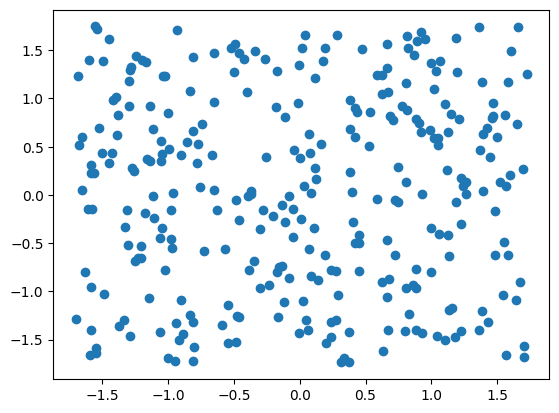

In [49]:
idx = 2

x_samples_unnorm = np.mod(x_samples * coord_std + coord_mean, 1000.)
x_samples_box = (x_samples_unnorm - coord_mean) / coord_std

plt.scatter(x_samples_box[idx, :, 0], x_samples_box[idx, :, 1])

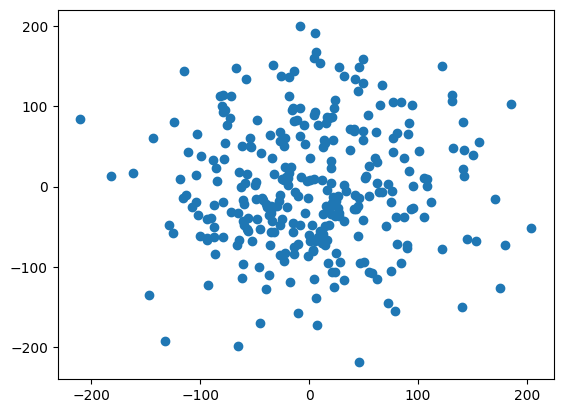

In [50]:
plt.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1])

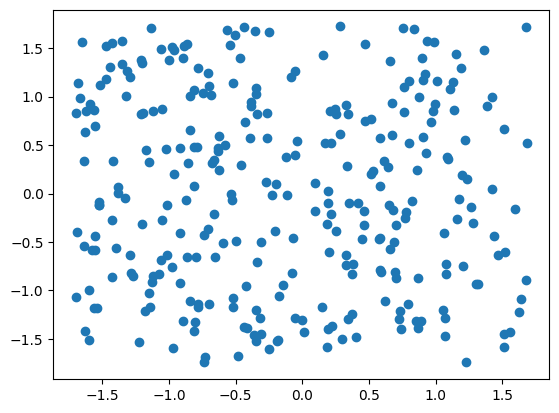

In [47]:
plt.scatter(x[idx, :, 0], x[idx, :, 1])